In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## CLUPI optical distortion

Reference:

[CLUPI FM Geometric Calibration](./doc/CLUPI_FM_GeometricCalibration_20190805_V1.0.pdf)

[Open CV optical distortion]( https://docs.opencv.org/2.4/doc/tutorials/calib3d/camera_calibration/camera_calibration.html#camera-calibration-with-opencv)

<img src="./img/clupi_fovs.png" width="100" title="CLUPI context" />



In [40]:
width = 2652
half_width = width/2
height = 1768
half_height = height/2


calibration_results = {

28E-2 : {
    'fx': 13616.126338849,
    'fy': 13616.126338849,
    'cx': 1048.9536340664,
    'cy':  693.43003744259,
   'distortion' : [
    0.90795278846644,
   -0.81549917806834,
   -0.015467154966426,
   -0.024081314487023,
   -0.021714843651652    
    ]
},


1 : {
    'fx': 12979.313699206,
    'fy': 12979.313699206,
    'cx': 1059.0009439107,
    'cy': 716.27511432891,
    
   'distortion' : [
     0.82640045036451,
    -0.80990580903775,
    -0.013565578400063,
    -0.020481752564741,
    -0.024481529915831

    ]
},

2.5 : {

    'fx': 13167.381556084,
    'fy': 13167.381556084,
    'cx': 1488.0073428712,
    'cy': 1090.7177140844,
   'distortion' : [
     0.84478595905046,
    -0.77452686325751,
     0.016311335023569,
     0.013922403608605,
     0.040406969232604
    ]
}
}





\begin{equation*} \rho = 1+ K_1r^2 + K_2r^4 + K_3r^6\end{equation*}
\begin{equation*} r^2 = x'^2 + y'^2 \end{equation*}
\begin{equation*} x" = x' \rho + 2P_1x'y' + P_2(r^2 + 2x'^2) \end{equation*}
\begin{equation*} y" = y' \rho + P_1(r^2 + 2y'^2) + 2P_2x'y' \end{equation*}



0.28
rho 1.0000000009161953 1.0178852127611129
xp -0.07703759556589647 0.11765801271707534
xpp -0.07826882388483211 0.11851080532197122
up -16.76456034259627 2662.6117318490988
horizontal range in pixels -16.76456034259627 11.61173184909876
vertical range in pixels -10.820528155076431 10.520987443269632

1
rho 1.0000000003712946 1.017470686305101
xp -0.08159144377375543 0.1226566437165849
xpp -0.08283473960023728 0.12365464528707346
up -16.137126552821428 2663.9533754556714
horizontal range in pixels -16.137126552821428 12.953375455671448
vertical range in pixels -11.176874231707075 10.200514976047998

2.5
rho 1.0000000003885259 1.0162867984735013
xp -0.11300708014978612 0.08832376066382296
xpp -0.11407654229893864 0.08960575423620933
up -14.08201617768077 2667.8804985200586
horizontal range in pixels -14.08201617768077 16.88049852005861
vertical range in pixels -9.91486629149108 10.993311903404447


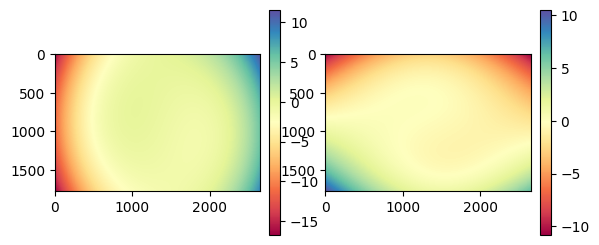

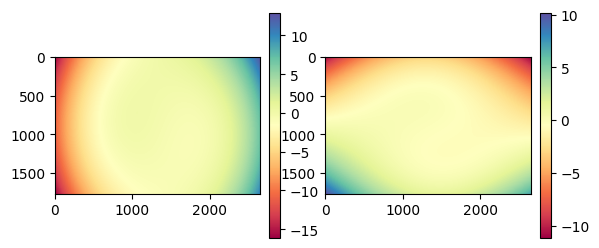

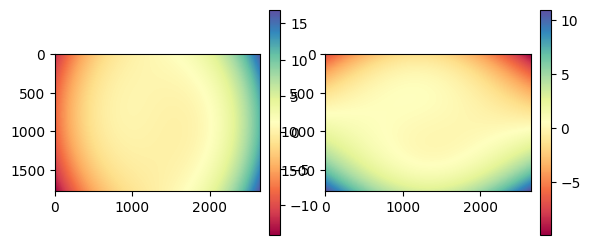

In [41]:

for focal_distance in calibration_results.keys():
    calibration = calibration_results[focal_distance]
    print()
    print(f'{focal_distance}')
    print(f'{"=" * 25}')

    k1, k2, p1, p2, k3 = calibration['distortion']

    cx = calibration['cx']
    cy = calibration['cy']

    fx = calibration['fx']
    fy = calibration['fy']

    u, v = np.meshgrid(np.arange(0, width), np.arange(0, height))


    xp =  (u - cx) / fx
    yp =  (v - cy) / fy

    r_2 = np.power(xp, 2) + np.power(yp, 2) 

    rho = 1  + k1 * r_2  + k2 * np.power(r_2, 2) + k3 * np.power(r_2, 3)
    print('rho', rho.min(), rho.max())
    print('xp', xp.min(), xp.max())

    htg_1 =  (2 * p1 * xp * yp) 
    htg_2 =  (p2 * (r_2 + 2 * np.power(xp, 2)))
    xpp = (xp * rho) + htg_1 + htg_2

    vtg_1 =  (2 * p2 * xp * yp) 
    vtg_2 =  (p1 * (r_2 + 2 * np.power(yp, 2))) 
    ypp = yp * rho + vtg_1 + vtg_2


    up = ((xpp * fx) + cx)
    vp = ((ypp * fy) + cy)

    print('xpp', xpp.min(), xpp.max())
    print('up', up.min(), up.max())


    horiz_dif = up - u
    print('horizontal range in pixels', horiz_dif.min(), horiz_dif.max())

    vert_dif = vp - v
    print('vertical range in pixels', vert_dif.min(), vert_dif.max())

    cmap_name = 'Spectral'
    
    fig, ((subplot_1, subplot_2)) = plt.subplots(1, 2)
    im_1 = subplot_1.imshow(horiz_dif, cmap=cmap_name)
    plt.colorbar(im_1, ax=subplot_1,fraction=0.05, pad=0.04)
    im_2 = subplot_2.imshow(vert_dif, cmap=cmap_name)
    plt.colorbar(im_2, ax=subplot_2,fraction=0.05, pad=0.04)


